In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ta.trend import MACD
from ta.momentum import RSIIndicator
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor
import pickle
import os


In [2]:
!pip install xgboost


   ---------------------------------------- 0.0/150.0 MB ? eta -:--:--
   ---------------------------------------- 1.3/150.0 MB 9.6 MB/s eta 0:00:16
    --------------------------------------- 3.7/150.0 MB 10.9 MB/s eta 0:00:14
   - -------------------------------------- 5.5/150.0 MB 11.2 MB/s eta 0:00:13
   -- ------------------------------------- 8.7/150.0 MB 11.4 MB/s eta 0:00:13
   -- ------------------------------------- 11.0/150.0 MB 11.7 MB/s eta 0:00:12
   --- ------------------------------------ 13.6/150.0 MB 11.6 MB/s eta 0:00:12
   ---- ----------------------------------- 16.3/150.0 MB 11.8 MB/s eta 0:00:12
   ----- ---------------------------------- 18.9/150.0 MB 11.7 MB/s eta 0:00:12
   ----- ---------------------------------- 21.2/150.0 MB 11.8 MB/s eta 0:00:11
   ------ --------------------------------- 23.9/150.0 MB 11.7 MB/s eta 0:00:11
   ------- -------------------------------- 26.5/150.0 MB 11.7 MB/s eta 0:00:11
   ------- -------------------------------- 28.8/150.0

In [7]:
df = pd.read_csv('../data/reliance.csv')
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')

# Convert to numeric in case some columns are strings
df[['Open', 'High', 'Low', 'Close', 'Volume']] = df[['Open', 'High', 'Low', 'Close', 'Volume']].apply(pd.to_numeric, errors='coerce')

df.head()


,Date,Close,High,Low,Open,Volume
1,2024-01-01,1290.744263,1299.016237,1282.223134,1285.910692,4030540.0
2,2024-01-02,1301.432983,1303.077427,1282.148458,1288.128164,7448800.0
3,2024-01-03,1287.281006,1312.545235,1284.241274,1300.585825,9037536.0
4,2024-01-04,1293.933350,1300.511122,1285.188128,1289.623028,9612778.0
5,2024-01-05,1299.439697,1305.494222,1294.606127,1297.047791,8086406.0


In [8]:
df['RSI'] = RSIIndicator(close=df['Close']).rsi()
macd = MACD(close=df['Close'])
df['MACD'] = macd.macd()
df['MACD_Signal'] = macd.macd_signal()
df['SMA7'] = df['Close'].rolling(window=7).mean()
df['SMA21'] = df['Close'].rolling(window=21).mean()
df.dropna(inplace=True)


In [9]:
features = ['Open', 'High', 'Low', 'Volume', 'RSI', 'MACD', 'MACD_Signal', 'SMA7', 'SMA21']
target = 'Close'

X = df[features]
y = df[target]


In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)


In [11]:
model = XGBRegressor(n_estimators=500, learning_rate=0.05, max_depth=6, subsample=0.9)
model.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=500,
             n_jobs=None, num_parallel_tree=None, ...)

In [12]:
y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.2f}")


MAE: 11.61
RMSE: 16.21
R² Score: 0.97


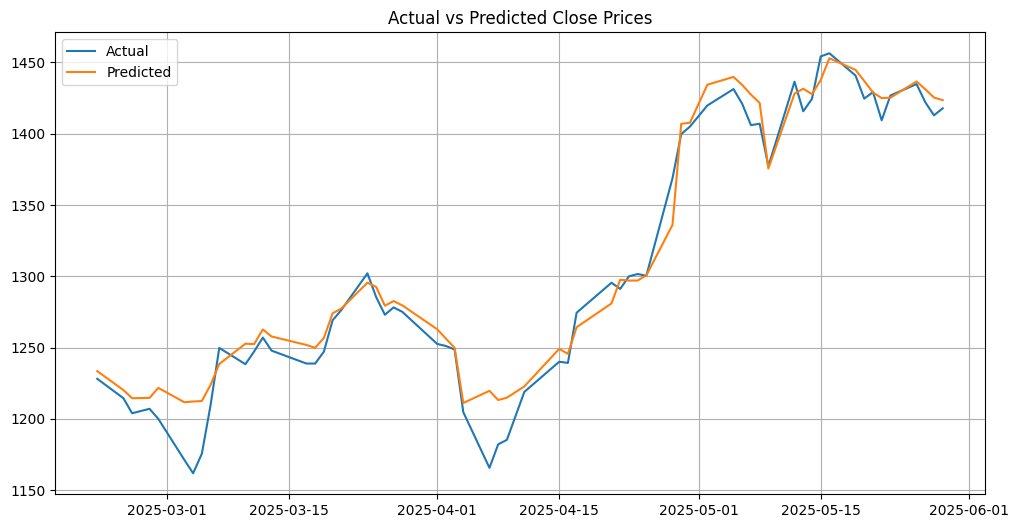

In [13]:
plt.figure(figsize=(12, 6))
plt.plot(df['Date'].iloc[-len(y_test):], y_test, label="Actual")
plt.plot(df['Date'].iloc[-len(y_test):], y_pred, label="Predicted")
plt.title("Actual vs Predicted Close Prices")
plt.legend()
plt.grid(True)
plt.show()


🔥 Excellent! An R² score of 0.97 means your model is very accurate — it explains 97% of the variance in the closing price predictions. The MAE and RMSE are also low, indicating solid performance.

✅ Summary of Your XGBoost Model


Metric	          Value	                 Meaning
MAE	             11.61	          Avg. prediction error is ₹11.61
RMSE	         16.21	          Slight penalty for larger errors
R² Score	     0.97	          97% of actual prices explained by model

In [15]:
os.makedirs("../models", exist_ok=True)

with open("../models/reliance.pkl", "wb") as f:
    pickle.dump(model, f)

print("✅ Model saved to ../models/reliance.pkl")


✅ Model saved to ../models/reliance.pkl
